<a href="https://colab.research.google.com/github/Manya-v20/Blockchain-dApp-Fake-Product-Detection-/blob/main/Compclass24(main).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
torch.cuda.is_available()


True

In [ ]:

import gc, torch, os
gc.collect()
torch.cuda.empty_cache()

!nvidia-smi


Tue Oct 28 02:44:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P0             27W /   70W |    1398MiB /  15360MiB |     14%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:

!pip uninstall -y torch torchvision torchaudio transformers datasets tokenizers huggingface-hub
!pip install torch==2.4.0+cu124 torchvision==0.19.0+cu124 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cu124
!pip install transformers==4.44.2 datasets==3.0.1 tokenizers==0.19.1 sentence-transformers==3.0.1 scikit-learn tqdm supabase


In [ ]:
import torch
print(torch.__version__, torch.version.cuda)


2.8.0+cu126 12.6


In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


CUDA available: True
CUDA device count: 1
Device name: Tesla T4


In [ ]:
import torch
print(torch.__version__, torch.version.cuda)


2.8.0+cu126 12.6


In [ ]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = ""  #cpu import
import torch, random, gc
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.utils.class_weight import compute_class_weight
from datasets import Dataset
from transformers import (
    DistilBertTokenizerFast, DistilBertForSequenceClassification,
    Trainer, TrainingArguments, DataCollatorWithPadding
)

# re-enable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
torch.cuda.init()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
CSV_PATH = "/content/drive/MyDrive/Company_classifier/mples_dataset.csv"
df = pd.read_csv(CSV_PATH)

print("Dataset shape:", df.shape)
print(df.head())

# Basic cleaning
df = df.drop_duplicates(subset=["text", "label"]).dropna(subset=["text", "label"])
print(df["label"].value_counts())


Dataset shape: (800, 3)
                                                text label  word_count
0  Logo\n\n\nMain Laboratory: Unit 34 53-57 Link ...   coa         419
1  Logo\n\n\nSuite 2, 92 Cleveland Street\nGreens...   coa         360
2  ANALYTICA\nLABORATORIES\n\n\n\n\n\n\n\n\n\n\n\...   coa         354
3  Logo\n\n\nSuite 2, 92 Cleveland Street\nGreens...   coa         343
4  Logo\n\n\nMain Laboratory: Unit 34 53-57 Link ...   coa         250
label
coa            400
air-monitor    348
Name: count, dtype: int64


In [ ]:
labels = df["label"].unique().tolist()
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for label, i in label2id.items()}
df["label_id"] = df["label"].map(label2id)


In [ ]:
train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df["label_id"], random_state=42
)


In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, padding=True, max_length=256)

train_ds = Dataset.from_pandas(train_df[["text", "label_id"]]).rename_column("label_id", "labels").map(tokenize_fn, batched=True)
val_ds = Dataset.from_pandas(val_df[["text", "label_id"]]).rename_column("label_id", "labels").map(tokenize_fn, batched=True)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/598 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

In [ ]:
class_weights = compute_class_weight("balanced", classes=np.unique(df["label_id"]), y=df["label_id"])
class_weights = torch.tensor(class_weights, dtype=torch.float)

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=len(label2id),
    id2label=id2label, label2id=label2id
)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    report_to="none"
)

data_collator = DataCollatorWithPadding(tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


/tmp/ipython-input-1975289681.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.011885,1.000000,1.000000
2,No log,0.002761,1.000000,1.000000
3,No log,0.001763,1.000000,1.000000
4,No log,0.001420,1.000000,1.000000
5,No log,0.001326,1.000000,1.000000


TrainOutput(global_step=190, training_loss=0.06135983718068976, metrics={'train_runtime': 179.5303, 'train_samples_per_second': 16.655, 'train_steps_per_second': 1.058, 'total_flos': 198038760990720.0, 'train_loss': 0.06135983718068976, 'epoch': 5.0})

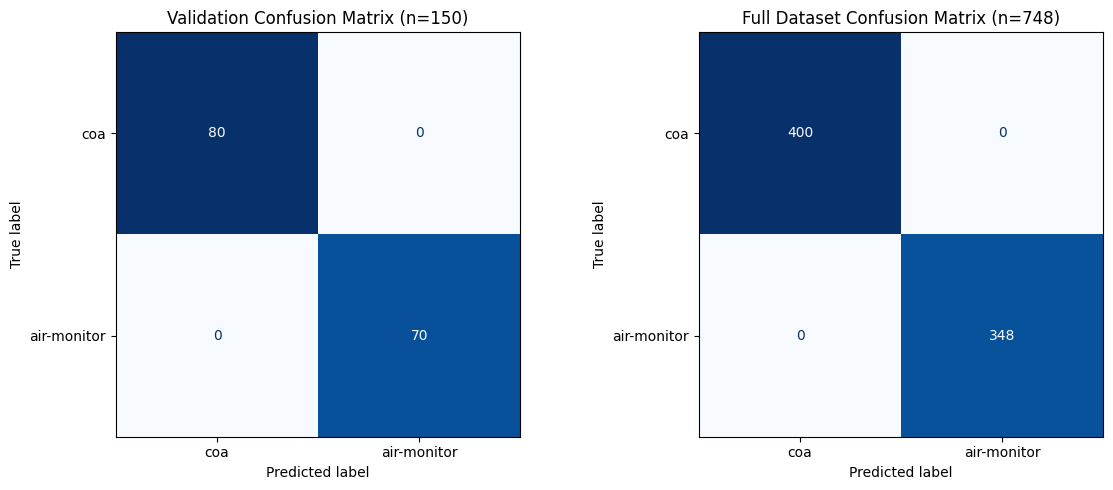

Validation Confusion Matrix:
 [[80  0]
 [ 0 70]]

Full Dataset Confusion Matrix:
 [[400   0]
 [  0 348]]


In [ ]:
# Dual Confusion Matrices: Validation + Full Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from datasets import concatenate_datasets

#Validation Set
preds_val = trainer.predict(val_ds)
y_true_val = preds_val.label_ids
y_pred_val = preds_val.predictions.argmax(axis=1)
cm_val = confusion_matrix(y_true_val, y_pred_val)

#Full Dataset (Train + Val)
full_ds = concatenate_datasets([train_ds, val_ds])
preds_full = trainer.predict(full_ds)
y_true_full = preds_full.label_ids
y_pred_full = preds_full.predictions.argmax(axis=1)
cm_full = confusion_matrix(y_true_full, y_pred_full)

# Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Validation confusion matrix
ConfusionMatrixDisplay(cm_val, display_labels=list(label2id.keys())).plot(
    ax=axes[0], cmap="Blues", colorbar=False
)
axes[0].set_title(f"Validation Confusion Matrix (n={len(val_ds)})")

# Full dataset confusion matrix
ConfusionMatrixDisplay(cm_full, display_labels=list(label2id.keys())).plot(
    ax=axes[1], cmap="Blues", colorbar=False
)
axes[1].set_title(f"Full Dataset Confusion Matrix (n={len(full_ds)})")

plt.tight_layout()
plt.show()

print("Validation Confusion Matrix:\n", cm_val)
print("\nFull Dataset Confusion Matrix:\n", cm_full)


#748 fields in full dataset due to dropping of non tokenized fields and null fields



In [ ]:
print("Original train_df:", len(train_df))
print("Tokenized train_ds:", len(train_ds))
print("Original val_df:", len(val_df))
print("Tokenized val_ds:", len(val_ds))
print("Combined total:", len(train_ds) + len(val_ds))


Original train_df: 598
Tokenized train_ds: 598
Original val_df: 150
Tokenized val_ds: 150
Combined total: 748


In [ ]:
MODEL_DIR = "/content/fine_tuned_distilbert_new"
trainer.save_model(MODEL_DIR)
tokenizer.save_pretrained(MODEL_DIR)


('/content/fine_tuned_distilbert_new/tokenizer_config.json',
 '/content/fine_tuned_distilbert_new/special_tokens_map.json',
 '/content/fine_tuned_distilbert_new/vocab.txt',
 '/content/fine_tuned_distilbert_new/added_tokens.json',
 '/content/fine_tuned_distilbert_new/tokenizer.json')

In [ ]:
!pip install supabase

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 4.0 MB/s eta 0:00:00


In [ ]:
from supabase import create_client
from sentence_transformers import SentenceTransformer
from getpass import getpass
from tqdm import tqdm
import time

SUPABASE_URL = "https://hyywhbgrinaydjzjjzmk.supabase.co"
SUPABASE_KEY = getpass("Enter your Supabase service_role key: ")

supabase = create_client(SUPABASE_URL, SUPABASE_KEY)
embed_model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

def safe_insert_batch(batch, retries=3):
    for attempt in range(retries):
        try:
            supabase.table("documents").insert(batch).execute()
            return True
        except Exception as e:
            print(f"⚠️ Batch insert failed (attempt {attempt+1}): {e}")
            time.sleep(2 ** attempt)
    return False

BATCH_SIZE = 50
rows = []

for i, (_, row) in enumerate(tqdm(df.iterrows(), total=len(df)), start=1):
    embedding = embed_model.encode(row["text"]).tolist()
    rows.append({
        "filename": "mples_dataset.csv",
        "label": row["label"],
        "content": row["text"],
        "embedding": embedding
    })

    if i % BATCH_SIZE == 0 or i == len(df):
        safe_insert_batch(rows)
        print(f"✅ Inserted {i} rows")
        rows = []


Enter your Supabase service_role key: ··········


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

  7%|▋         | 53/748 [00:05<03:17,  3.52it/s]

✅ Inserted 50 rows


 14%|█▍        | 103/748 [00:10<03:16,  3.29it/s]

✅ Inserted 100 rows


 20%|██        | 152/748 [00:15<02:18,  4.32it/s]

✅ Inserted 150 rows


 27%|██▋       | 201/748 [00:19<02:12,  4.12it/s]

✅ Inserted 200 rows


 34%|███▎      | 252/748 [00:24<01:51,  4.43it/s]

✅ Inserted 250 rows


 40%|████      | 301/748 [00:30<02:34,  2.90it/s]

✅ Inserted 300 rows


 47%|████▋     | 352/748 [00:35<01:46,  3.71it/s]

✅ Inserted 350 rows


 54%|█████▍    | 403/748 [00:38<00:40,  8.62it/s]

✅ Inserted 400 rows


 60%|██████    | 450/748 [00:41<01:02,  4.75it/s]

✅ Inserted 450 rows


 67%|██████▋   | 501/748 [00:47<01:33,  2.65it/s]

✅ Inserted 500 rows


 74%|███████▍  | 553/748 [00:53<00:51,  3.77it/s]

✅ Inserted 550 rows


 81%|████████  | 606/748 [00:56<00:12, 11.59it/s]

✅ Inserted 600 rows


 87%|████████▋ | 654/748 [00:58<00:07, 11.86it/s]

✅ Inserted 650 rows


 94%|█████████▍| 706/748 [01:01<00:03, 12.52it/s]

✅ Inserted 700 rows


100%|██████████| 748/748 [01:03<00:00, 11.75it/s]

✅ Inserted 748 rows


In [ ]:
def classify_distilbert_only(text):
    model.eval()  # set evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256)
    inputs = {k: v.to(device) for k, v in inputs.items()}  # move inputs to same device

    with torch.no_grad():
        logits = model(**inputs).logits
        pred = torch.argmax(logits, dim=1).item()

    return id2label[pred]


In [ ]:
# concise predictions for random samples
test_texts = df.sample(5, random_state=1)

for i, row in test_texts.iterrows():
    text = row["text"]
    true_label = row["label"]
    pred_label = classify_distilbert_only(text)

    print("-" * 80)
    print(f"Sample ID: {i}")
    print(f"True Label: {true_label} | Predicted Label: {pred_label}")
    print(f"Snippet: {text[:300].replace('\n', ' ')}...")


--------------------------------------------------------------------------------
Sample ID: 265
True Label: coa | Predicted Label: coa
Snippet: Logo   Main Laboratory: Unit 34 53-57 Link Drive, Yatala QLD 4207 Enquiries: 1800 628 433 www.octief.com.au      Asbestos Bulk Sample Analysis Report Certificate No CER4906115333        Client: Ferry-Walter   Client Contact: Ms. Jewel Koelpin   Telephone: 425-367-8785   Project: JO52474   Site Locat...
--------------------------------------------------------------------------------
Sample ID: 535
True Label: air-monitor | Predicted Label: air-monitor
Snippet: Daphne Becker Building 165 Collins Station South Minerva, State, 78148    Freeda Casper IV Building 7614 Stehr Shores Suite 009 West Kaychester, State, 60632-3253 Attention: Ms. Idella Kulas IV Phone: 916-260-1405 Email: natasha83@hotmail.com    Lab Reference: 21-69451} Submitted by: Dr. Daryl Kutch...
--------------------------------------------------------------------------------
Sample 

In [ ]:
mismatches = df.sample(20, random_state=2)  # test a few
for i, row in mismatches.iterrows():
    pred = classify_distilbert_only(row["text"])
    if pred != row["label"]:
        print("-" * 80)
        print(f"WRONG PREDICTION: True={row['label']} | Predicted={pred}")
        print(f"Snippet: {row['text'][:300].replace('\n',' ')}...")
# no output = 100% accuracy since it prints mismatched items

In [ ]:
def search_supabase(query_text, k=5):
    """
    Returns the top-k most similar documents to the given text query using Supabase vector search.
    """
    embedding = embed_model.encode(query_text).tolist()

    response = supabase.rpc(
        "match_documents",
        {"query_embedding": embedding, "match_count": k}
    ).execute()

    return response.data


In [ ]:
results = search_supabase("Generate invoice for steel order 100")
print(results)


[{'id': 'ed8e6c7a-5f4b-4c49-bc82-4a9f88385b16', 'content': "ANALYTICA\nLABORATORIES\n\n\n\n\n\n\n\n\n\n\n\nAnalytica Laboratories Limited\n24 Sydney Street\nPetone\nWellington\nsales@analytica.co.nz\nwww.analytica.co.nz\n\n\n\n\nCertificate of Analysis\n\n\n\n\n\nPaucek Ltd\n655 Graham Plains\nMarkston\n\n\n\nAttention:\nKelsie Stiedemann Jr.\n\n\nPhone:\n+1 (276) 389-4268\n\n\nEmail:\nstiedemann.kenneth@labadie.biz\n\n\n\n\n\nLab Reference:\n21-71996\n\n\nSubmitted by:\nKali Thompson DDS\n\n\nDate Received:\n27/10/2025\n\n\nTesting Initiated:\n27/10/2025\n\n\nDate Completed:\n27/10/2025\n\n\nOrder Number:\nPO52734\n\n\nReference:\nJO93932\n\n\n\n\n\n\n\n\nSampling Site:\n9955 Lyda Highway Suite 743, Irmafort\n\n\nDescription of Work:\nBulk - 9955 Lyda Highway Suite 743, Irmafort\n\n\n\n\n\n\nReport Comments\nSamples were collected by yourselves (or your agent) and analysed as received at Analytica Laboratories. Samples were in acceptable condition unless otherwise noted on this report

In [ ]:
# Label mapping from training
id2label = {0: "coa", 1: "air-monitor"}

def classify_user_input(text):
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        pred = torch.argmax(outputs.logits, dim=1).item()
    label = id2label[pred]
    return label


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("✅ Using device:", device)


✅ Using device: cuda


In [ ]:
import re
from IPython.display import Markdown, display

def normalize_phone(phone):
    if not phone:
        return None
    digits = re.sub(r"[^\d]", "", phone)
    if len(digits) == 10:
        return f"{digits[:3]}-{digits[3:6]}-{digits[6:]}"
    elif len(digits) == 11 and digits.startswith("1"):
        return f"+1 {digits[1:4]}-{digits[4:7]}-{digits[7:]}"
    return phone  # fallback if weird format

def extract_and_display_full_info_v3(text):
    txt = text.replace("\r", "")
    txt = re.sub(r"[ \t]+", " ", txt)
    txt = re.sub(r"\n{3,}", "\n\n", txt.strip())

    label = classify_user_input(txt)

    parsed = {
        "Predicted Label": label,
        "Header 1": None, "Header 2": None,
        "Phone": None, "Email": None,
        "Client": None, "Submitted By": None,
        "Certificate No": None, "Report No": None,
        "Lab Reference": None, "Order Number": None, "Reference": None,
        "Date Received": None, "Testing Initiated": None, "Date Completed": None,
        "Sampling Site": None, "Description of Work": None,
    }

    # headers
    blocks = [b.strip() for b in re.split(r"\n\s*\n", txt) if b.strip()]
    if len(blocks) > 0:
        parsed["Header 1"] = blocks[0]
    if len(blocks) > 1:
        parsed["Header 2"] = blocks[1]

    # contact info
    if m := re.search(r"Phone[:\-\s]*([\+\d\.\-\s\(\)]+)", txt, re.I):
        parsed["Phone"] = normalize_phone(m.group(1).strip())
    if m := re.search(r"Email[:\-\s]*([A-Za-z0-9._%+\-]+@[A-Za-z0-9.\-]+\.[A-Za-z]{2,})", txt, re.I):
        parsed["Email"] = m.group(1).strip()

    # clients
    if m := re.search(r"Attention[:\-\s]*(.*)", txt, re.I):
        parsed["Client"] = m.group(1).strip()
    elif m := re.search(r"Client[:\-\s]*(.*)", txt, re.I):
        parsed["Client"] = m.group(1).strip()
    if m := re.search(r"Submitted by[:\-\s]*(.*)", txt, re.I):
        parsed["Submitted By"] = m.group(1).strip()

    # ids & references
    for label_name, pattern in {
        "Certificate No": r"Certificate No[:\-\s]*(.*)",
        "Report No": r"Report No[:\-\s]*(.*)",
        "Lab Reference": r"Lab Reference[:\-\s]*(.*)",
        "Order Number": r"Order Number[:\-\s]*(.*)",
        "Reference": r"(?<!Lab\s)Reference[:\-\s]*(.*)",
    }.items():
        if m := re.search(pattern, txt, re.I):
            parsed[label_name] = m.group(1).strip()

    #dates
    for label_name, pattern in {
        "Date Received": r"Date Received[:\-\s]*(\d{2}/\d{2}/\d{4})",
        "Testing Initiated": r"Testing Initiated[:\-\s]*(\d{2}/\d{2}/\d{4})",
        "Date Completed": r"Date Completed[:\-\s]*(\d{2}/\d{2}/\d{4})",
    }.items():
        if m := re.search(pattern, txt, re.I):
            parsed[label_name] = m.group(1)

    # locations
    if m := re.search(r"Sampling Site[:\-\s]*\n*(.*?)(?=\n\n|\Z)", txt, re.I | re.S):
        parsed["Sampling Site"] = m.group(1).strip()
    if m := re.search(r"Description of Work[:\-\s]*\n*(.*?)(?=\n\n|\Z)", txt, re.I | re.S):
        parsed["Description of Work"] = m.group(1).strip()

    # validation
    issues = []
    if parsed["Predicted Label"] == "coa" and not parsed["Certificate No"]:
        issues.append("missing_certificate_number")
    if parsed["Predicted Label"] == "air-monitor" and not parsed["Report No"] and not parsed["Lab Reference"]:
        issues.append("missing_report_number")
    valid = len(issues) == 0

    # markdown
    md = f"""
#### 🧾 Document Summary
**Predicted Label:** `{parsed['Predicted Label']}`
**Validity:** {'✅ Valid' if valid else '⚠ Invalid'}
**Issues:** {', '.join(issues) if issues else 'None'}

#### 📋 Extracted Key Fields
- **Client:** {parsed.get('Client') or 'None'}
- **Submitted By:** {parsed.get('Submitted By') or 'None'}
- **Phone:** {parsed.get('Phone') or 'None'}
- **Email:** {parsed.get('Email') or 'None'}
- **Certificate No:** {parsed.get('Certificate No') or 'None'}
- **Report No:** {parsed.get('Report No') or 'None'}
- **Lab Reference:** {parsed.get('Lab Reference') or 'None'}
- **Order Number:** {parsed.get('Order Number') or 'None'}
- **Reference:** {parsed.get('Reference') or 'None'}

#### 📆 Dates
- Date Received: {parsed.get('Date Received') or 'None'}
- Testing Initiated: {parsed.get('Testing Initiated') or 'None'}
- Date Completed: {parsed.get('Date Completed') or 'None'}

#### 📍 Sampling & Description
- Sampling Site: {parsed.get('Sampling Site') or 'None'}
- Description of Work: {parsed.get('Description of Work') or 'None'}

#### 🏢 Headers
**Header 1:**
{parsed.get('Header 1') or 'N/A'}

**Header 2:**
{parsed.get('Header 2') or 'N/A'}
    """

    display(Markdown(md))
    return parsed


In [ ]:
text = """Althea Reilly Building
9788 Morar Prairie
Goyetteberg, State, 90907



Zechariah Kohler DVM Building
2556 Mosciski Street Suite 960
East Christianaton, State, 01847
Attention: Rory Keebler I
Phone: 470.347.8928
Email: carlie.okeefe@ohara.com



Lab Reference: 21-28572}
Submitted by: Eriberto Bailey III
Date Received: 27/10/2025
Testing Initiated: 27/10/2025
Date Completed: 27/10/2025
Order Number: PO77553
Reference: JO39968




Sampling Site:


2118 Little Mountain, Natbury, 67466 - Asbestos Air Monitoring and Sampling


Description of Work:


Bulk/Air-2118 Little Mountain, Natbury, 67466 - Asbestos Air Monitoring and Sampling




Airborne Fibres (Quantitative)
Sample Details




Laboratory ID
Client Sample ID
Sample Location
Sample Description
Date Sampled
Date Analysed




21-28572-1
JL687121
Foyer
Air filter
yesterday
today


21-28572-2
JL687122
Hall
Air filter
yesterday
today


21-28572-3
JL687123
Kitchen
Air filter
yesterday
today


21-28572-4
JL687124
Reception
Air filter
yesterday
today



Information in the above table supplied by the client: Client Sample ID, Sample Location, Date Sampled.

Analysis Result




Laboratory ID
Client Sample ID
Sample Location
Monitoring Type
Sampling Time
Average Flow Rate
Fields Counted
Fibre Count
Fibre Concentration


Units



L/min
fields
fibres
fibres/mL




21-28572-1
JL687121
Foyer
Clearance
0934 - 1517 353 min
2.0
100
2.0
&lt;0.01


21-28572-2
JL687122
Hall
Clearance
0934 - 1517 353 min
2.0
100
2.0
&lt;0.01


21-28572-3
JL687123
Kitchen
Clearance
0934 - 1517 353 min
2.0
100
2.0
&lt;0.01


21-28572-4
JL687124
Reception
Clearance
0934 - 1517 353 min
2.0
100
2.0
&lt;0.01




Method Summary
Airborne Fibres (Quantitative)

Filters examined in accordance with Safe Work Australia's Guidance Note on the Membrane Filter
Method for the Estimation of Airborne Asbestos Fibres, 2nd Edition, 2005 [NOHSC:3003 (2005)].
The sample results reported in the above table should be compared with the recommended control
levels outlined in Section 30.3.1 of the Health and Safety at Work Act Approved Code of Practice - Management and Removal of Asbestos, November 2016 (amended December 2016).
The recommended control levels, listed below, provide an indication of the occupational exposurelevels relevant to quality control and re-occupancy for an area.

&lt; 0.01 fibres/mL - trace level
&gt;= 0.01 fibres/mL but < 0.02 fibres/mL - above recommended control levels
&gt;= 0.02 fibres/mL â€“ notifiable event

Control levels refer to respirable airborne asbestos fibre concentrations which, if exceeded,
indicate there is a need to review current control measures or take other action. Air monitoring
should be completed to confirm the removal area is no longer above the control levels once
remediation actions have been completed.
The laboratory reporting limit for fibre concentration is 0.01 fibres/mL and results below this limit
are reported as < 0.01 fibres/mL.
"""
parsed = extract_and_display_full_info_v3(text)
# inspect specific keys:
print("Phone:", parsed.get("Phone"))
print("Email:", parsed.get("Email"))
print("Report No:", parsed.get("Report No"))
print("Sample rows:", len(parsed.get("Sample Details Table", [])))



#### 🧾 Document Summary
**Predicted Label:** `air-monitor`
**Validity:** ✅ Valid
**Issues:** None

#### 📋 Extracted Key Fields
- **Client:** Rory Keebler I
- **Submitted By:** Eriberto Bailey III
- **Phone:** 470-347-8928
- **Email:** carlie.okeefe@ohara.com
- **Certificate No:** None
- **Report No:** None
- **Lab Reference:** 21-28572}
- **Order Number:** PO77553
- **Reference:** JO39968

#### 📆 Dates
- Date Received: 27/10/2025
- Testing Initiated: 27/10/2025
- Date Completed: 27/10/2025

#### 📍 Sampling & Description
- Sampling Site: 2118 Little Mountain, Natbury, 67466 - Asbestos Air Monitoring and Sampling
- Description of Work: Bulk/Air-2118 Little Mountain, Natbury, 67466 - Asbestos Air Monitoring and Sampling

#### 🏢 Headers
**Header 1:**
Althea Reilly Building
9788 Morar Prairie
Goyetteberg, State, 90907

**Header 2:**
Zechariah Kohler DVM Building
2556 Mosciski Street Suite 960
East Christianaton, State, 01847
Attention: Rory Keebler I
Phone: 470.347.8928
Email: carlie.okeefe@ohara.com
    

Phone: 470-347-8928
Email: carlie.okeefe@ohara.com
Report No: None
Sample rows: 0


In [ ]:
# --- Example 1: COA ---
coa_example = """Certificate No: CER4906115333
Date Received: 27/10/2025
Asbestos Bulk Sample Analysis Report
Client: Ferry-Walter
"""
extract_and_display_full_info_v3(coa_example)



#### 🧾 Document Summary
**Predicted Label:** `air-monitor`
**Validity:** ⚠ Invalid
**Issues:** missing_report_number

#### 📋 Extracted Key Fields
- **Client:** Ferry-Walter
- **Submitted By:** None
- **Phone:** None
- **Email:** None
- **Certificate No:** CER4906115333
- **Report No:** None
- **Lab Reference:** None
- **Order Number:** None
- **Reference:** None

#### 📆 Dates
- Date Received: 27/10/2025
- Testing Initiated: None
- Date Completed: None

#### 📍 Sampling & Description
- Sampling Site: None
- Description of Work: None

#### 🏢 Headers
**Header 1:**
Certificate No: CER4906115333
Date Received: 27/10/2025
Asbestos Bulk Sample Analysis Report
Client: Ferry-Walter

**Header 2:**
N/A
    

{'Predicted Label': 'air-monitor',
 'Header 1': 'Certificate No: CER4906115333\nDate Received: 27/10/2025\nAsbestos Bulk Sample Analysis Report\nClient: Ferry-Walter',
 'Header 2': None,
 'Phone': None,
 'Email': None,
 'Client': 'Ferry-Walter',
 'Submitted By': None,
 'Certificate No': 'CER4906115333',
 'Report No': None,
 'Lab Reference': None,
 'Order Number': None,
 'Reference': None,
 'Date Received': '27/10/2025',
 'Testing Initiated': None,
 'Date Completed': None,
 'Sampling Site': None,
 'Description of Work': None}

In [ ]:
# --- Example 2: Air Monitor ---
air_example = """Report No: J33681-220125-1
Date Analysed: 27/10/2025
Airborne Fibres (Quantitative)
Client: Emard-Stark
"""
extract_and_display_full_info_v3(air_example)



#### 🧾 Document Summary
**Predicted Label:** `air-monitor`
**Validity:** ✅ Valid
**Issues:** None

#### 📋 Extracted Key Fields
- **Client:** Emard-Stark
- **Submitted By:** None
- **Phone:** None
- **Email:** None
- **Certificate No:** None
- **Report No:** J33681-220125-1
- **Lab Reference:** None
- **Order Number:** None
- **Reference:** None

#### 📆 Dates
- Date Received: None
- Testing Initiated: None
- Date Completed: None

#### 📍 Sampling & Description
- Sampling Site: None
- Description of Work: None

#### 🏢 Headers
**Header 1:**
Report No: J33681-220125-1
Date Analysed: 27/10/2025
Airborne Fibres (Quantitative)
Client: Emard-Stark

**Header 2:**
N/A
    

{'Predicted Label': 'air-monitor',
 'Header 1': 'Report No: J33681-220125-1\nDate Analysed: 27/10/2025\nAirborne Fibres (Quantitative)\nClient: Emard-Stark',
 'Header 2': None,
 'Phone': None,
 'Email': None,
 'Client': 'Emard-Stark',
 'Submitted By': None,
 'Certificate No': None,
 'Report No': 'J33681-220125-1',
 'Lab Reference': None,
 'Order Number': None,
 'Reference': None,
 'Date Received': None,
 'Testing Initiated': None,
 'Date Completed': None,
 'Sampling Site': None,
 'Description of Work': None}

In [ ]:
from IPython.display import display, Markdown
import ipywidgets as widgets

def analyze_user_document():
    """
    Accepts multi-line user input for document text
    and runs info extraction cleanly.
    """
    textarea = widgets.Textarea(
        value='',
        placeholder='Paste your document text here...',
        description='📄 Document:',
        layout=widgets.Layout(width='100%', height='300px')
    )

    analyze_button = widgets.Button(description="Analyze Document", button_style='success')

    output = widgets.Output()

    def on_analyze_click(b):
        with output:
            output.clear_output()
            user_text = textarea.value.strip()
            if not user_text:
                print("⚠ Please paste some text before analyzing.")
                return
            print("\n📄 Analyzing document...\n")
            parsed = extract_and_display_full_info_v3(user_text)
            print("\n✅ Extraction complete.")
            return parsed

    analyze_button.on_click(on_analyze_click)

    display(widgets.VBox([textarea, analyze_button, output]))


In [ ]:
analyze_user_document()


In [ ]:
analyze_user_document()


In [ ]:
ground_truth_data = [
    {
        "text": """Certificate No: CER4906115333
        Date Received: 27/10/2025
        Asbestos Bulk Sample Analysis Report
        Client: Ferry-Walter
        """,
        "expected": {
            "Predicted Label": "coa",
            "Certificate No": "CER4906115333",
            "Date Received": "27/10/2025",
            "Client": "Ferry-Walter",
        }
    },
    {
        "text": """Report No: J33681-220125-1
        Date Analysed: 27/10/2025
        Airborne Fibres (Quantitative)
        Client: Emard-Stark
        """,
        "expected": {
            "Predicted Label": "air-monitor",
            "Report No": "J33681-220125-1",
            "Date Completed": None,
            "Client": "Emard-Stark",
        }
    }
]


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_extraction(extraction_func, data):
    y_true, y_pred = [], []
    fields = set()

    # collect all field names from expected dicts
    for d in data:
        fields.update(d["expected"].keys())

    field_metrics = {f: {"tp": 0, "fp": 0, "fn": 0} for f in fields}

    for sample in data:
        extracted = extraction_func(sample["text"])

        for field, true_val in sample["expected"].items():
            pred_val = extracted.get(field)
            if true_val and pred_val and str(true_val).strip().lower() == str(pred_val).strip().lower():
                field_metrics[field]["tp"] += 1
            elif pred_val and not true_val:
                field_metrics[field]["fp"] += 1
            elif true_val and not pred_val:
                field_metrics[field]["fn"] += 1

    # compute precision, recall, f1 per field
    results = {}
    for field, vals in field_metrics.items():
        tp, fp, fn = vals["tp"], vals["fp"], vals["fn"]
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0
        results[field] = {"precision": precision, "recall": recall, "f1": f1}

    # macro-averaged score
    macro_f1 = sum(v["f1"] for v in results.values()) / len(results)
    print(f"\nOverall Macro-F1: {macro_f1:.2f}")
    return results

# Run evaluation
results = evaluate_extraction(extract_and_display_full_info_v3, ground_truth_data)

for f, metrics in results.items():
    print(f"{f:20s} | Precision: {metrics['precision']:.2f} | Recall: {metrics['recall']:.2f} | F1: {metrics['f1']:.2f}")



#### 🧾 Document Summary
**Predicted Label:** `air-monitor`
**Validity:** ⚠ Invalid
**Issues:** missing_report_number

#### 📋 Extracted Key Fields
- **Client:** Ferry-Walter
- **Submitted By:** None
- **Phone:** None
- **Email:** None
- **Certificate No:** CER4906115333
- **Report No:** None
- **Lab Reference:** None
- **Order Number:** None
- **Reference:** None

#### 📆 Dates
- Date Received: 27/10/2025
- Testing Initiated: None
- Date Completed: None

#### 📍 Sampling & Description
- Sampling Site: None
- Description of Work: None

#### 🏢 Headers
**Header 1:**
Certificate No: CER4906115333
 Date Received: 27/10/2025
 Asbestos Bulk Sample Analysis Report
 Client: Ferry-Walter

**Header 2:**
N/A
    


#### 🧾 Document Summary
**Predicted Label:** `air-monitor`
**Validity:** ✅ Valid
**Issues:** None

#### 📋 Extracted Key Fields
- **Client:** Emard-Stark
- **Submitted By:** None
- **Phone:** None
- **Email:** None
- **Certificate No:** None
- **Report No:** J33681-220125-1
- **Lab Reference:** None
- **Order Number:** None
- **Reference:** None

#### 📆 Dates
- Date Received: None
- Testing Initiated: None
- Date Completed: None

#### 📍 Sampling & Description
- Sampling Site: None
- Description of Work: None

#### 🏢 Headers
**Header 1:**
Report No: J33681-220125-1
 Date Analysed: 27/10/2025
 Airborne Fibres (Quantitative)
 Client: Emard-Stark

**Header 2:**
N/A
    


Overall Macro-F1: 0.83
Certificate No       | Precision: 1.00 | Recall: 1.00 | F1: 1.00
Report No            | Precision: 1.00 | Recall: 1.00 | F1: 1.00
Predicted Label      | Precision: 1.00 | Recall: 1.00 | F1: 1.00
Client               | Precision: 1.00 | Recall: 1.00 | F1: 1.00
Date Completed       | Precision: 0.00 | Recall: 0.00 | F1: 0.00
Date Received        | Precision: 1.00 | Recall: 1.00 | F1: 1.00


In [ ]:
import pandas as pd
df = pd.DataFrame(results).T
df.style.background_gradient(cmap="Blues")


,precision,recall,f1
Certificate No,1.000000,1.000000,1.000000
Report No,1.000000,1.000000,1.000000
Predicted Label,1.000000,1.000000,1.000000
Client,1.000000,1.000000,1.000000
Date Completed,0.000000,0.000000,0.000000
Date Received,1.000000,1.000000,1.000000


In [ ]:
correct = 0
total = 0
for d in ground_truth_data:
    extracted = extract_and_display_full_info_v3(d["text"])
    for field, true_val in d["expected"].items():
        if str(extracted.get(field)).strip().lower() == str(true_val).strip().lower():
            correct += 1
        total += 1
print("Overall extraction accuracy:", correct / total)



#### 🧾 Document Summary
**Predicted Label:** `air-monitor`
**Validity:** ⚠ Invalid
**Issues:** missing_report_number

#### 📋 Extracted Key Fields
- **Client:** Ferry-Walter
- **Submitted By:** None
- **Phone:** None
- **Email:** None
- **Certificate No:** CER4906115333
- **Report No:** None
- **Lab Reference:** None
- **Order Number:** None
- **Reference:** None

#### 📆 Dates
- Date Received: 27/10/2025
- Testing Initiated: None
- Date Completed: None

#### 📍 Sampling & Description
- Sampling Site: None
- Description of Work: None

#### 🏢 Headers
**Header 1:**
Certificate No: CER4906115333
 Date Received: 27/10/2025
 Asbestos Bulk Sample Analysis Report
 Client: Ferry-Walter

**Header 2:**
N/A
    


#### 🧾 Document Summary
**Predicted Label:** `air-monitor`
**Validity:** ✅ Valid
**Issues:** None

#### 📋 Extracted Key Fields
- **Client:** Emard-Stark
- **Submitted By:** None
- **Phone:** None
- **Email:** None
- **Certificate No:** None
- **Report No:** J33681-220125-1
- **Lab Reference:** None
- **Order Number:** None
- **Reference:** None

#### 📆 Dates
- Date Received: None
- Testing Initiated: None
- Date Completed: None

#### 📍 Sampling & Description
- Sampling Site: None
- Description of Work: None

#### 🏢 Headers
**Header 1:**
Report No: J33681-220125-1
 Date Analysed: 27/10/2025
 Airborne Fibres (Quantitative)
 Client: Emard-Stark

**Header 2:**
N/A
    

Overall extraction accuracy: 0.875
